# Homework 4

**Harvard University**<br>
**Fall 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Saturday, October 6th, 2018 at 11:59pm

**Instructions:**

- Upload your final answers in the form of a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

### Collaborators

** Place the name of everyone who's submitting this assignment here**

Karama Tarap

Alexander Noll

Using 1 late day

<div class="answer-separator">
------------------------
</div>

In [1]:
import numpy as np
import scipy.stats
import scipy.special

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
import pandas as pd
import seaborn as sns
%matplotlib inline

## Question 1: Rubber Chickens Bawk Bawk!

In the competitive rubber chicken retail market, the success of a company is built on satisfying the exacting standards of a consumer base with refined and discriminating taste. In particular, customer product reviews are all important. But how should we judge the quality of a product based on customer reviews?

On Amazon, the first customer review statistic displayed for a product is the ***average rating***. The following are the main product pages for two competing rubber chicken products, manufactured by Lotus World and Toysmith respectively:


Lotus World |  Toysmith
- |  - 
![alt](https://am207.github.io/2018fall/homeworks/lotus1.png) |  ![alt](https://am207.github.io/2018fall/homeworks/toysmith1.png)

Clicking on the 'customer review' link on the product pages takes us to a detailed break-down of the reviews. In particular, we can now see the number of times a product is rated a given rating (between 1 and 5 stars).

Lotus World |  Toysmith
- |  - 
![alt](https://am207.github.io/2018fall/homeworks/lotus2.png) |  ![alt](https://am207.github.io/2018fall/homeworks/toysmith2.png)

(The images above are also included on canvas in case you are offline, see below)

In the following, we will ask you to compare these two products using the various rating statistics. **Larger versions of the images are available in the data set accompanying this notebook**.

Suppose that for each product, we can model the probability of the value each new rating as the following vector:
$$
\theta = [\theta_1, \theta_2, \theta_3, \theta_4, \theta_5]
$$
where $\theta_i$ is the probability that a given customer will give the product $i$ number of stars.

**1.1. Suppose you are told that customer opinions are very polarized in the retail world of rubber chickens, that is, most reviews will be 5 stars or 1 stars (with little middle ground). Choose an appropriate Dirichlet prior for $\theta$. Recall that the Dirichlet pdf is given by:
$$
f_{\Theta}(\theta) = \frac{1}{B(\alpha)} \prod_{i=1}^k \theta_i^{\alpha_i - 1}, \quad B(\alpha) = \frac{\prod_{i=1}^k\Gamma(\alpha_i)}{\Gamma\left(\sum_{i=1}^k\alpha_i\right)},
$$
where $\theta_i \in (0, 1)$ and $\sum_{i=1}^k \theta_i = 1$, $\alpha_i > 0 $ for $i = 1, \ldots, k$.**

Interpreting the $\alpha_i$ (minus 1) as "ratings that happenend before the data", let us define the alpha vector to be

$$ \alpha = \left(5, 2, 1, 2, 5\right) \:. $$

We can do a *prior predictive check* to see that we are getting results that we want.

In [2]:
prior_alpha = [5.0, 2.0, 1.0, 2.0, 5.0]
dirichlet = scipy.stats.dirichlet(alpha=prior_alpha)

Text(0.5,1,'Prior distribution of ratings')

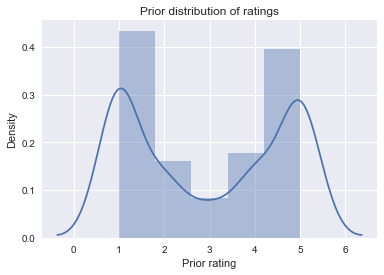

In [3]:
n_prior_draws = 1000
prior_draws = np.empty(n_prior_draws)
for i in range(n_prior_draws):
    theta_sample = dirichlet.rvs(1)[0]
    prior_draws[i] = np.random.choice(range(1, 6), size=1, p=theta_sample)

sns.distplot(prior_draws, bins=5)
plt.xlabel("Prior rating")
plt.ylabel("Density")
plt.title("Prior distribution of ratings")

Looks reasonable. The only question is whether we should make the prior "stronger" (i.e. we could, for example, multiply the current prior $\alpha$ by 10).

**1.2. Write an expression for the posterior pdf, using a using a multinomial model for observed ratings. Recall that the multinomial pdf is given by:**
$$
f_{\mathbf{X}\vert  \Theta}(\mathbf{x}) = \frac{n!}{x_1! \ldots x_k!} \theta_1^{x_1} \ldots \theta_k^{x_k}
$$
**where $n$ is the total number of trials, $\theta_i$ is the probability of event $i$ and $\sum_i \theta_i = 1$, and $x_i$ is count of outcome $i$ and $\sum_i x_i = n$. **

By Bayes' rule, the posterior (which is a function of the $\theta_i$) is proportional to the product of the prior and the likelihood. Note that as the posterior is a function of the $\theta$ parameters, we only need to find the functional dependence on these parameteres, and then normalize so that we really have a pdf. So let us write down the posterior:

$$
f(\theta \vert \mathbf{x}) \propto f_\Theta(\theta) f_{\mathbf{X}\vert  \Theta}(\mathbf{x}) \\
\propto \prod_{i=1}^5 \theta_i^{\alpha_i - 1} \prod_{i=1}^5\theta_i^{x_i} = \\
= \prod_{i=1}^5 \theta_i^{\alpha_i - 1 + x_1} = \\
= \prod_{i=1}^5 \theta_i^{(\alpha_i + x_i) - 1}
$$

Now, this is a Dirichlet pdf again, but with parameters $\alpha_i + x_i$ and thus

$$
f(\theta \vert \mathbf{x}) = \frac{1}{B(\alpha + \mathbf x)} \prod_{i=1}^k \theta_i^{(\alpha_i + x_i) - 1} \:.
$$

***Note:* The data you will need in order to define the likelihood function should be read off the image files included in the dataset.**

**1.3. Sample 1,000 values of $\theta$ from the *posterior distribution*.**

We take the reviews from the images above, and round them to their nearest integer (which we actually don't necessarily have to do).

In [4]:
toysmith_reviews = np.array([round(percent * 162) for percent in [0.06, 0.04, 0.06, 0.17, 0.67]])
lotus_reviews = np.array([round(percent * 410) for percent in [0.14, 0.08, 0.07, 0.11, 0.60]])

Using the data, it's easy to update the $\alpha$ parameter, by just adding the reviews.

In [5]:
toysmith_dirichlet = scipy.stats.dirichlet(alpha=prior_alpha + toysmith_reviews)
lotus_dirichlet = scipy.stats.dirichlet(alpha=prior_alpha + lotus_reviews)

Now, we can sample from the $\theta$ posterior distribution:

In [6]:
n_posterior = 1000
toysmith_posterior_samples = toysmith_dirichlet.rvs(n_posterior)
lotus_posterior_samples = lotus_dirichlet.rvs(n_posterior)

Let us use the posterior to calculate the posterior average rating distribution:

In [7]:
toysmith_posterior_means = (toysmith_posterior_samples * np.arange(1, 6)).sum(axis=1)
lotus_posterior_means = (lotus_posterior_samples * np.arange(1, 6)).sum(axis=1)

Text(0.5,1,'Posterior average rating')

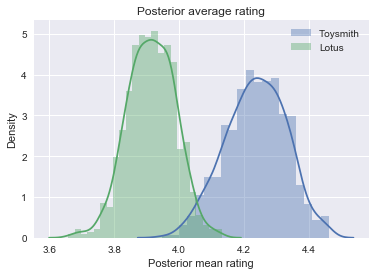

In [8]:
sns.distplot(toysmith_posterior_means, label="Toysmith")
sns.distplot(lotus_posterior_means, label="Lotus")
plt.legend()
plt.xlabel("Posterior mean rating")
plt.ylabel("Density")
plt.title("Posterior average rating")

**1.4. Sample 1,000 values of $x$ from the *posterior predictive distribution*.**

We sample a single entry from the multinomial for each posterior parameter:

In [9]:
toysmith_posterior_predictive = np.vstack([np.random.multinomial(n=1, pvals=toysmith_posterior_samples[i, :]) for i in range(1000)])
lotus_posterior_predictive = np.vstack([np.random.multinomial(n=1, pvals=lotus_posterior_samples[i, :]) for i in range(1000)])

In [10]:
print("Average toysmith rating over posterior predictve: {:3f}".format((toysmith_posterior_predictive * np.arange(1, 6)).sum(axis=1).mean()))
print("Average toysmith rating over posterior predictve: {:3f}".format((lotus_posterior_predictive * np.arange(1, 6)).sum(axis=1).mean()))


Average toysmith rating over posterior predictve: 4.229000
Average toysmith rating over posterior predictve: 3.923000


**1.5. Name at least two major potential problems with using only the average customer ratings to compare products.**

**  (**Hint:** if product 1 has a higher average rating than product 2, can we conclude that product 1 is better liked? If product 1 and product 2 have the same average rating, can we conclude that they are equally good?)**

*Problem 1:* Consider the following two scenarios. Product A has 100% solid 4 star ratings, product B has 80% 5 star ratings and 20 % 1 star ratings. Both would get an average of 4 stars, but the reviews of product B indicate that users are either very happy or very disappointed with the product (e.g. 20% of sold products don't work at all). These two situations are very different, and I would in most cases not buy product B, but if the item sold is not very important to me, I might be perfectly happy with product A.

*Problem 2*: Let's consider the case that the product we are interested in are **movies**. Suppose, we have movie A that has 20% 1-star, 20% 2-star and 60% 50-star. Movie B has 40% 1-star and 60% 2-star. Although, movie A has a better average rating, I would not necessarily say that it is the better movie. After all, I don't care whether the movie is super bad or bad. In either case, I don't want to watch the movie.

**1.6. Using the samples from your *posterior distribution*, determine which rubber chicken product is superior. Justify your conclusion with sample statistics.**

Let's plot a summary of the posterior distribution. We associate each $\theta_i$ with a star rating and show a plot of the posterior distribution of $\theta_i$ for both chickens.

In [11]:
lotus = pd.DataFrame(lotus_posterior_samples, columns=['*', '**', '***', '****', '*****'])
lotus_long = pd.melt(lotus, value_vars=['*', '**', '***', '****', '*****'])
lotus_long['Chicken'] = "Lotus"
toysmith = pd.DataFrame(toysmith_posterior_samples, columns=['*', '**', '***', '****', '*****'])
toysmith_long = pd.melt(toysmith, value_vars=['*', '**', '***', '****', '*****'])
toysmith_long['Chicken'] = "Toysmith"

all_data = lotus_long.append(toysmith_long)

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:637: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data[hue_mask])
/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:932: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data[hue_mask])


Text(0.5,1,'Posterior marginal per star rating for both rubber chickens')

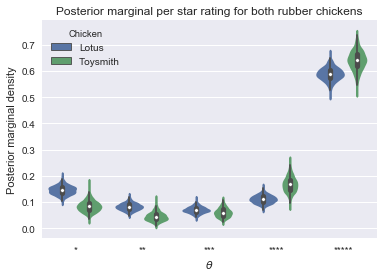

In [12]:
sns.violinplot(x='variable', y='value', hue='Chicken', data=all_data)
plt.xlabel(r'$\theta$')
plt.ylabel("Posterior marginal density")
plt.title("Posterior marginal per star rating for both rubber chickens")

From this plot, I would go with **Toysmith**, as the $\theta_{4, 5}$ values tend to be higher.

**1.7. Using the samples from your *posterior predictive distribution*, determine which rubber chicken product is superior. Justify your conclusion with sample statistics.**

We make a plot of the counts for every rating in the posterior predictive distribution.

In [13]:
lotus_posterior_predictive_summary = np.sum(lotus_posterior_predictive, axis=0)
toysmith_posterior_predictve_summary = np.sum(toysmith_posterior_predictive, axis=0)

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


Text(0.5,1,'Rating distribution in posterior preditive')

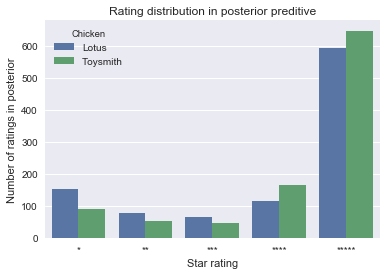

In [14]:
posterior_predictive_summary = pd.DataFrame([lotus_posterior_predictive_summary, toysmith_posterior_predictve_summary],
                                           columns=['*', '**', '***', '****', '*****'])

posterior_predictive_summary['Chicken'] = ['Lotus', 'Toysmith']
posterior_predictive_sumary_long = posterior_predictive_summary.melt(
                                           value_vars=['*', '**', '***', '****', '*****'],
                                           id_vars='Chicken')

sns.barplot(x="variable", y="value", hue="Chicken", data=posterior_predictive_sumary_long)
plt.xlabel("Star rating")
plt.ylabel("Number of ratings in posterior")
plt.title("Rating distribution in posterior preditive")

From the plot above, **Toysmith** is the better choice.

**1.8. Finally, which rubber chicken product is superior?**

**  (**Note:** we're not looking for "the correct answer" here, any sound decision based on a statistically correct interpretation of your model will be fine)**

From what we've seen above, I would go for **Toysmith**: let us characterize 4 and 5 star ratings as good, 1 and 2 star ratings as bad and we drop 3 star ratings. 

In [15]:
posterior_predictive_summary['Good'] = posterior_predictive_summary['****'] + posterior_predictive_summary['*****']
posterior_predictive_summary['Bad'] = posterior_predictive_summary['*'] + posterior_predictive_summary['**']
posterior_predictive_summary[['Good', 'Bad', 'Chicken']]

,Good,Bad,Chicken
0,708,227,Lotus
1,812,141,Toysmith


Doing this, Toysmith has more than 80% good ratings, whereas Lotus only has 70% of good ratings. On the other hand, Toysmith only has 10% of bad ratings, whereas Lotus has 20% bad ratings.

## Question 2: He Who is Not Courageous Enough to Take Risks Will Accomplish Nothing In Life

**No Coding required**

Consider a setting where the feature and label space are $\mathcal{X} = \mathcal{Y} = [0, 1]$.    In this exercise we will consider both the square loss and the absolute loss, namely:

$$ \mathbb{l}_{sq}(y_1, y_2) = (y_1 - y_2)^2 $$
$$ \mathbb{l}_{abs}(y_1, y_2) = \left \vert y_1 - y_2 \right \vert $$


Let (X, Y) be random, with the following with joint probability density $p_{XY}(x, y) = 2y$, where $x, y \ \in \  [0, 1]$.  We define **statistical risk** as follows:

**Definition (Statistical Risk)** For a prediction rule $f$ and a joint distribution of features and labels $P_{XY}$ the statistical risk $\mathcal{R}(f)$ of $f$ is defined as 

$$\mathcal{R}(f) \equiv \mathbb{E}_{XY}\left[\mathbb{l}(f(X),Y)\ \vert \ f \right]$$,

where $(X, Y) \sim P_{XY}$.  The conditional statement ensures the definition is sensible even if $f$ is a random quantity.


**2.1. Show that in this case $X$ and $Y$ are independent, meaning the feature $X$ carries no information about Y.**

The definition of independence is that $P_{XY}(x, y) = P_X(x) P_Y(y)$. Here $P_X$ and $P_Y$ are the *marginal distribution*, respectively. This property is straightforward to prove (and actually "clear by inspection"):

$$
P_Y(y) = \int_0^1 P_{XY}(x, y) dx = \int_0^1 2y dx = 2y
$$

$$
P_X(x) = \int_0^1P_{XY}(x, y)dy = \int_0^1 2y dy = 1 \:.
$$

These two functions clearly satisfy the property of independence.

**2.2. What is the risk of prediction rule $f(x) = \frac{1}{2}$ according to the two loss functions?**

Let us start by calculating $\mathbb l_{sq}$ for this prediction rule:

$$ 
\mathcal R_f^{l_2} = \int_0^1 \int_0^1 \left(y - \frac{1}{2}\right) ^ 2 2 ydx dy = \\ 
= \int_0^1 \left(y - \frac{1}{2}\right) ^ 2 2 ydy = \\ 
= \int_0^1 \left( \frac{1}{4} - y + y ^ 2 \right) 2y dy = \\
= \int_0^1 \left(\frac{y}{2} - 2 y ^ 2 + 2 y ^ 3 \right) dy = \\
=\left(\frac{y^2}{4} - \frac{2y^3}{3} + \frac{2y^4}{4}\right)\biggr\rvert_0^1 = \\
= \frac{1}{4} - \frac{2}{3} + \frac{1}{2} = \frac{1}{12}
$$

Next, the absolute loss:

$$ 
\mathcal R_f^{abs} = \int_0^1 \lvert\frac{1}{2} - y\rvert 2y dx = \\
= \int_0^{1/2}\left(\frac{1}{2}-y\right) 2y dy + \int_{1/2}^1\left(y - \frac{1}{2}\right)2y dy = \\
= \int_0^{1/2}\left(y-2y^2\right) dy + \int_{1/2}^1\left(2y^2-y\right)dy = \\
= \left(\frac{y^2}{2} - \frac{2y^3}{3}\right)\biggr\rvert_0^{1/2} + \left(\frac{2y^3}{3}-\frac{y^2}{2}\right)\biggr\rvert_{1/2}^1 = \\
= \frac{1}{4}\frac{1}{2} - \frac{2}{8\times 3} - \frac{2}{8\times 3} + \frac{1}{4}\frac{1}{2} + \frac{2}{3} - \frac{1}{2} = \\
= \frac{1}{4}
$$

**2.3. What is the risk of the prediction rule $f^*(x) = \frac{1}{\sqrt{2}}$ according to the two loss functions?**

$$ 
\mathcal R_{f^*}^{l_2} = \int_0^1 \int_0^1 \left(y - \frac{1}{\sqrt 2}\right) ^ 2 2 ydx dy = \\ 
= \int_0^1 \left(y - \frac{1}{\sqrt 2}\right) ^ 2 2 ydy = \\ 
= \int_0^1 \left( \frac{1}{2} - \sqrt 2 y + y ^ 2 \right) 2y dy = \\
= \int_0^1 \left(y - 2 \sqrt 2 y ^ 2 + 2 y ^ 3 \right) dy = \\
=\left(\frac{y^2}{2} - \frac{2 \sqrt 2 y^3}{3} + \frac{2y^4}{4}\right)\biggr\rvert_0^1 = \\
= \frac{1}{2} - \frac{2\sqrt 2}{3} + \frac{1}{2} = 1 - \frac{2\sqrt 2}{3}  \approx 0.05719
$$

In [16]:
1-2*np.sqrt(2)/3

0.05719095841793653

Now, the absolute loss:

$$ 
\mathcal R_f^{abs} = \int_0^1 \lvert\frac{1}{\sqrt 2} - y\rvert 2y dx = \\
= \int_0^{1/ \sqrt 2}\left(\frac{1}{\sqrt 2}-y\right) 2y dy + \int_{1/\sqrt 2}^1\left(y - \frac{1}{\sqrt 2}\right)2y dy = \\
= \int_0^{1/\sqrt 2}\left(\sqrt2 y-2y^2\right) dy + \int_{1/\sqrt2}^1\left(2y^2 - \sqrt 2y\right)dy = \\
= \left(\frac{y^2 \sqrt 2}{2} - \frac{2y^3}{3}\right)\biggr\rvert_0^{1/\sqrt 2} + \left(\frac{2y^3}{3}-\frac{y^2\sqrt 2}{2}\right)\biggr\rvert_{1/\sqrt 2}^1 = \\
= \frac{\sqrt 2}{2 \times 2} - \frac{2}{3}\frac{1}{2^{3/2}} - \frac{2}{3}\frac{1}{2^{3/2}} + \frac{\sqrt 2}{2 \times 2} + \frac{2}{3} - \frac{\sqrt 2}{2} = \\
= \frac{2 - \sqrt 2}{3} \approx 0.195
$$

**2.4. Show that $f^*$ has actually the smallest absolute loss risk among all prediction rules.**

**Hint (for 2.4):**

    * In general the Bayes predictor according to the absolute value loss is the median of the conditional distribution of $Y$ given $X = x$.

Using the hint, it's easy to prove that $f^*$ has the smalles absolute loss risk amoung all prediction rules. We need to establish only that $f^*$ is the median. Note that the median is simply the value of $y$ at which the cumulative distribution function has a value of 0.5. So let's calculate the CDF:

$$
P_Y(y) = \int_0^y p_Y(\tilde y) d \tilde y = \\
= \int_0^y 2\tilde y d\tilde y =
y^2
$$

Now, we want that a $y$ such that $y^2 = \frac{1}{2}$ or equivalently that $y=\frac{1}{\sqrt 2}$.

Let's actually prove the hint. We start by writing out the loss function:

$$
l(f^*) = \int \lvert x-f^*\rvert p(x) dx = \\
= \int_{-\infty}^{f^*} (f^* - x)p(x) dx + \int_{f^*}^{\infty}(x - f^*)p(x) dx = \\
= \int_{-\infty}^{f^*}f^*p(x) dx - \int_{-\infty}^{f^*} xp(x) dx + \int_{f^*}^{\infty}x p(x)dx - \int_{f^*}^{\infty} f^* p(x) dx
$$

Now let's calculcate the derivative with respect to $f^*$:

$$
\frac{d}{df^*} l(f^*) = \frac{d}{df^*} f^* \int_{-\infty}^{f^*} p(x) dx - \frac{d}{df^*} \int_{-\infty}^{f^*} xp(x) dx + \frac{d}{df^*} \int_{f^*}^{\infty} xp(x) dx - \frac{d}{df^*} f^* \int_{f^*}^{\infty} p(x) dx = \\
= \frac{d}{df^*} \left[f^*\left(2P(f^*) - 1 \right) \right] - 2 f^* p(f^*) = \\
\left(2 P(f^*) - 1\right) + 2f^* p(f^*) - 2f^* p(f^*) = 2 P(f^*) - 1
$$

At the median, i.e. $P(f^*) = \frac{1}{2}$, this expression is zero. Also, the second derivative is greater than or equal to zero, meaning that we have a minimum.

## Question 3: Maxwell's Demon Has a Wonderful Way of showing us What Really Matters

**Some Coding required**

**3.1. Find the entropy of the exponential probability density on support (0, $\infty$) with mean $\lambda$.**

Recall that the pdf of the exponential distribution with mean $\lambda$ is given by the following function $f(x)$:

$$
f(x) = 
\begin{cases}
\frac{1}{\lambda} e^{-x / \lambda} \quad \text{if } x \geq 0 \\
0 \quad \quad\:\: \text{if } x < 0
\end{cases}
$$

Also, recall the definition of entropy:

$$
S = \int_x p(x) \log p(x) dx
$$

In the case at hand, this gives:

$$
\begin{multline}
S = \int_{-\infty}^\infty f(x) \log f(x) dx =
  \int_0 ^ \infty \frac{1}{\lambda} e^{- x / \lambda} \log\left(\frac{1}{\lambda} e ^{- x/\lambda}\right)dx = 
  \int_0 ^ \infty \frac{1}{\lambda} e^{-x/\lambda} \left(\log \frac{1}{\lambda} - x/\lambda \right) dx =
  \int_0 ^ \infty \frac{1}{\lambda} e^{-x/\lambda} \log 1/\lambda dx - \int_0 ^ \infty \frac{1}{\lambda} e^{-x/\lambda} x/\lambda dx \\
  = \log 1/\lambda - 1
\end{multline}
$$

In the last equality, we used the $\int f(x) dx = 1$ and that $\int f(x) dx = \lambda$.

**3.2. Show that the exponential distribution $p^*$ is the maximum entropy distribution on support (0, $\infty$)  with specified mean $\lambda$. That is to say prove that for any continuous probability density function $p(x)$ on (0, $\infty$) with mean $\lambda$ then the entropy h(p) <= h($p^*$) with equality if and only if p is also the exponential with mean $\lambda$**

Let $p(x)$ denote a pdf on $(0, \infty)$ with mean $\lambda$. As in the lecture, let us calculate the Kullback-Leibler divergence 
$$D_{KL}(p, p^*) = \mathbb E_{p}\log\left(\frac{p}{p^*}\right) = H(p, p^*) - H(p) \geq 0 \:.$$

We'll prove that $H(p, p^*) = H(p)$, which concludes the proof by the inequality above.

$$H(p, p^*) = \mathbb E_p \left[\log p^*\right] = \mathbb E_p \left[\log 1/\lambda - x/\lambda\right] = \log 1/\lambda - 1 = H(p^*)$$

**We're familiar with the CLT as a way of approximating the sum of IID random variables with an appropriate Normal distribution.  Let's investigate this relationship by using the KL-Divergence.  Given n identically distributed Bernoulli variables $Y_i \sim Bern(p)$, then their sum approaches a Normal distribution.**

**3.3. Visualize this relationship by drawing n = 10,000 samples from a Bernoulli with p = 0.02.  These samples determine a random variable and thus a probability distribution (which in the last homework we called the empirical distribution of the data).  Visualize this probability distribution by plotting a normed histogram of the samples.  On your plot overlay the appropriately fitted Gaussian distribution.  Make sure to appropriately title and label your plot.**


Instead of sampling 10'000 samples from a Bernoulli and taking the sum of those, we directly sample from a binomial distribution with 10'000 trials. Note that a binomial $\text{Binom}(n, p)$ is the same as the sum of $n$ independent Bernoulli random variables $\text{Bernoulli}_i$, $\text{Binom}(n, p) = \sum_{i=1}^n \text{Bernoulli}_i(p)$. We use $m = 1000$ such binomial samples.

Next, what's the distribution that the CLT tells us to use? Note that the mean sample statistics $\mu = \frac{1}{n} \sum_{i=1}^n x_i$, where $x_i$ are the Bernoullis, follows a normal with variance $p(1-p)/n$ for large $n$. Thus, the sum of the Bernoullis, which is the random variabl that we are interested in, follows a normal with mean $np$ and variance $p(1-p) n$.

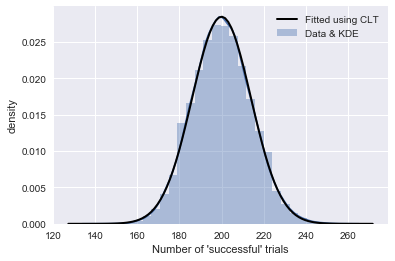

In [17]:
#np.random.seed(1)
n = 10000
p = 0.02
m = 100000

binomial_samples = np.random.binomial(n=n, p=p, size=m)

sns.distplot(binomial_samples, kde=True, bins=30, hist=True, label='Data & KDE')

mu = p * n
std =  np.sqrt(p * (1 - p) * n)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = scipy.stats.norm.pdf(x, mu, std)
plt.plot(x, y, 'k', linewidth=2, label='Fitted using CLT')
plt.xlabel("Number of 'successful' trials")
plt.ylabel("density")
plt.legend()

**3.4. From visual inspection are the two distributions close to each other?**

Yes, from visual inspection the blue (kernel density estimate) and black (fitted according to Central Limit Theorem) are very close.

**3.5. Formalize your answer to 3.3 and 3.4 by writing a program to compute the K-L divergence between the two distributions (the sum of 10000 sampled Bernoullis and the appropriate Gaussian).  What is the value of the KL divergence.**

We write a function to compute the KL divergence. It takes in the samples and two pdfs (as functions). It uses that the KL divergence $\int p(x) \log \frac{p(x)}{q(x)}$ can be written as $\mathbb E_p\left[\log\frac{p}{q}\right] \approx \frac{1}{n} \sum_i \log\frac{p(x_i)}{q(x_i)}$ where $x_i$ have been sampled from the distribution $p$.

In [18]:
def compute_divergence(x, d1, d2):
    """
    Compute the KL divergence between distribution d1 and d2 using on samples x
    
    :param x: samples
    :param d1: pdf
    :param d2: pdf
    """
    ps = d1(x)
    qs = d2(x)
    return np.mean(np.log(ps / qs))

d1 = lambda k: scipy.stats.binom.pmf(k, n=n, p=p)
d2 = lambda x: scipy.stats.norm.pdf(x, loc=mu, scale=std)
print("Estimated KL divergence: {:.4f}".format(compute_divergence(binomial_samples, d1=d1, d2=d2)))

Estimated KL divergence: 0.0004


We can actually also calculate the KL divergence directly using the formula.

In [19]:
ns = np.arange(1, 400)
ps = scipy.stats.binom.pmf(ns, n=n, p=p)
qs = scipy.stats.norm.logpdf(ns, loc=mu, scale=std)
div_semi_analytical = np.sum(ps * (np.log(ps) - qs))
print("Very accurately approximated KL divergence: {:.4f}".format(div_semi_analytical))

Very accurately approximated KL divergence: 0.0004


**3.6. Let's visualize the convergence of the sum of bernoulli RVs to a Gaussian as fortold by the CLT by repeating the process from 3.5 for various values of n.  We'll set our selection of sample sizes to the following: [100, 250, 500, 750, 1000, 2500, 5000, 7500, 10000, 50000, 100000].  Setting n to each of the specified sample sizes repeat the following procedure 10 times:**

* Draw n bernoulli samples using the Bernoulli parameter from 3.3 (p=0.02).
* Calculate the Kullback-Leibler divergence between the random variable defined by the sum of Bernoullis samples and the appropriately fitted gaussian. 

**For each sample size you should have 10 KL divergences. Construct a log scale (in both axes) plot of the Kullback-Leibler divergence and and the 3-$\sigma$ envelope against the sample size.  What can you convergence of the distributions in question?  What does this mean for the CLT?**

In [20]:
np.random.seed(666)
ns = [100, 250, 500, 750, 1000, 2500, 5000, 7500, 10000, 50000, 100000]

p = 0.02
m = 300000 # Number of samples per rep for every n
n_reps = 10

result = pd.DataFrame()

for n in ns:
    mu = p * n
    std =  np.sqrt(p * (1 - p) * n)
    d1 = lambda k: scipy.stats.binom.pmf(k, n=n, p=p)
    d2 = lambda x: scipy.stats.norm.pdf(x, loc=mu, scale=std)
    
    for i in range(n_reps):
        binomial_samples = np.random.binomial(n=n, p=p, size=m)
        df = pd.DataFrame({'n': [n], 'divergence': [compute_divergence(binomial_samples, d1, d2)]})
        result = result.append(df)

Text(0.5,1,'KL divergence between Binomial distribution and its CLT approximation')

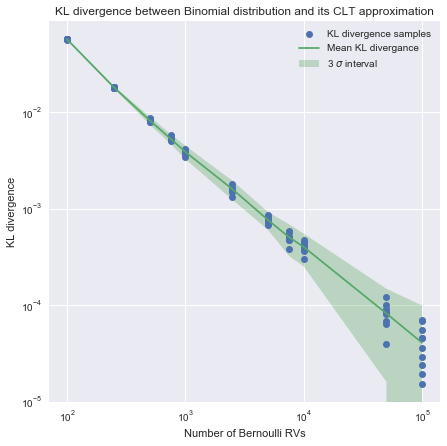

In [21]:
summary_df = result.groupby('n', as_index=False, group_keys=False).agg({'divergence': [np.mean, np.std]})
summary_divergence = summary_df['divergence']

f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
plt.plot(result['n'], result['divergence'], 'o', label='KL divergence samples')
plt.plot(ns, summary_divergence['mean'], label='Mean KL divergance')
plt.fill_between(ns, summary_divergence['mean'] + 3 * summary_divergence['std'], 
                 summary_divergence['mean'] - 3 * summary_divergence['std'], 
                 facecolor='green', interpolate=True, alpha=.2, label=r'3 $\sigma$ interval')
plt.legend()
plt.xlabel('Number of Bernoulli RVs')
plt.ylabel('KL divergence')
plt.title('KL divergence between Binomial distribution and its CLT approximation')

We see that the two distributions are converging at a scale that is linear on the log-log scale (which means that it is *polynomial* in original scales). This means that the central limit theorem applies better for larger $n$ (nothing new here). Also, increasing $n$ by a factor of ten, roughly reduces the KL divergence by a factor of 10, as can be seen from the plot.

## Q4: Marvel at the DC Flash Light Speed experiment

Simon Newcomb did an experiment in 1882 to measure the speed of light. These are the times required for light to travel 7442 metres. These are recorded as deviations from 24,800 nanoseconds.

This data is in the following dataset $D$.

In [22]:
light_speed = np.array([28, 26, 33, 24, 34, -44, 27, 16, 40, -2, 29, 22, 24, 21, 25,
                        30, 23, 29, 31, 19, 24, 20, 36, 32, 36, 28, 25, 21, 28, 29,
                        37, 25, 28, 26, 30, 32, 36, 26, 30, 22, 36, 23, 27, 27, 28,
                        27, 31, 27, 26, 33, 26, 32, 32, 24, 39, 28, 24, 25, 32, 25,
                        29, 27, 28, 29, 16, 23])

**4.1. Plot a histogram of the data. Are there outliers in the data?  What data points might you consider to be outliers?**

Text(0.5,0,"Deviation from 24'800 ns in ns")

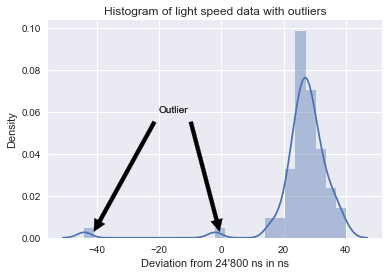

In [23]:
sns.distplot(light_speed)
plt.annotate('Outlier', xy=(-42, 0), xytext=(-20, 0.06),
            arrowprops=dict(facecolor='black', shrink=0.05)) 
plt.annotate('Outlier', xy=(0, 0), xytext=(-20, 0.06),
            arrowprops=dict(facecolor='black', shrink=0.05)) 
plt.title("Histogram of light speed data with outliers")
plt.ylabel("Density")
plt.xlabel("Deviation from 24'800 ns in ns")

The point $-44$ definitely looks like an outlier. $-2$ can be considered an outlier as well. We don't do a formal analysis (like interquartile range) here.

**4.2. We use a normal models with weakly informative priors to model this experiment. In particular assume uniform priors for both $\mu$ and $\sigma$:**

$$\mu \sim Uniform(0, 60)$$

$$\sigma \sim Uniform(0.1, 50)$$

Write down an expression for the posterior (joint) pdf $p(\mu, \sigma \vert D)$.

We use Bayes' theorem to write down an expression for the posterior distribution of $(\mu, \sigma)$.

$$
p(\mu, \sigma \vert D) = \frac{p(D\vert \mu, \sigma) p(\mu, \sigma)}{p(D)} = \frac{p(D\vert \mu, \sigma) p(\mu) p(\sigma)}{p(D)} \propto p(D\vert \mu, \sigma) p(\mu) p(\sigma) \propto 
\begin{cases}
p(D\vert \mu, \sigma) \text{ if } 0\leq \mu \leq 60 \text{ and } 0.1 \leq \sigma \leq 50  \\
0 \quad \text{else}\:,
\end{cases}
$$

where we used that the priors are independent. 

**
4.3. Set up a 500 point grid in both the $\mu$ space and the $\sigma$ space. Compute the normalized posterior on this grid and make a contour plot of it. **

**Hint: `np.meshgrid` is your friend**

Note that $p(\mu\vert D) = 0$ for $\mu < 0$ or $\mu > 60$. Similarly, $p(\sigma \vert D) = 0$ for $\sigma < 0.1$ or $\sigma > 50$. Thus, in defining the grid of points in $(\mu, \sigma)$, we can restrict the values to these ranges, respectively.

In [24]:
n_grid = 500

def compute_pdf(n_grid, x):

    mus = np.linspace(0, 60, num=n_grid)
    sigmas = np.linspace(0.1, 50, num=n_grid)
    pdf_grid = np.zeros((mus.shape[0], sigmas.shape[0]))

    for i, mu in enumerate(mus):
        for j, sigma in enumerate(sigmas):
            pdf_grid[i, j] = np.exp(np.sum(scipy.stats.norm.logpdf(x, loc=mu, scale=sigma)))

    pdf_grid = pdf_grid / np.sum(pdf_grid)
    return pdf_grid, mus, sigmas

pdf_grid, mus, sigmas = compute_pdf(n_grid, light_speed)

Next, we make a countour plot of the posterior:

Text(0,0.5,'$\\mu$')

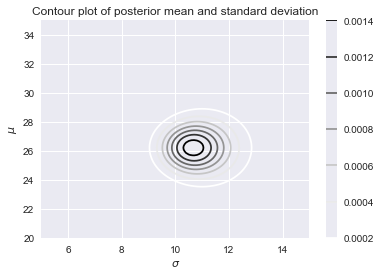

In [25]:
plt.contour(sigmas, mus, pdf_grid)
#cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar()
plt.title("Contour plot of posterior mean and standard deviation")
plt.xlim(5, 15)
plt.ylim(20, 35)
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$\mu$')

** 4.4. Use this normalized posterior to sample from the grid, posterior samples of size 500000. That is the posterior should be of shape `(500000, 2)`. (Hint: one way to do it is to first flatten the meshgrid into a grid of shape (250000, 2). Flatten the posterior probabilities as well into a size 250000 vector. Then sample 500000 indices and use them to index the grid). Plot the $\mu$ and $\sigma$ marginal posteriors.**

We sample from the posterior as suggested, but without meshgrid. We simply recompute the indices after flattening (using integer division and modulo).

In [26]:
n_samples = 500000
def compute_samples(n_samples, mus, sigmas, pdf_grid):
    sampled = np.random.choice(np.arange(n_grid * n_grid), replace=True, size=n_samples, p=pdf_grid.reshape(-1))
    sampled_posterior = np.zeros((n_samples, 2))

    for k in range(n_samples):
        (i, j) = (sampled[k] // n_grid, sampled[k] % n_grid)
        sampled_posterior[k, 0] = mus[i]
        sampled_posterior[k, 1] =  sigmas[j]
        
    return sampled_posterior

sampled_posterior = compute_samples(n_samples, mus, sigmas, pdf_grid)

Now, we plot the marginal distributions. The results seem consistent with the density plot of the pdf.

Text(0.5,1,'Posetrior standard deviation')

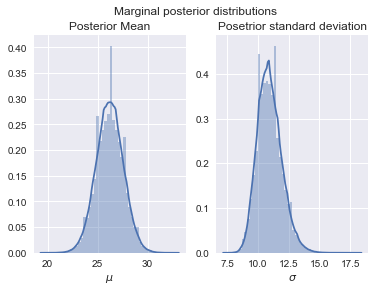

In [27]:
f, axarr = plt.subplots(ncols=2)
f.suptitle('Marginal posterior distributions')
sns.distplot(sampled_posterior[:, 0], ax=axarr[0], axlabel=r"$\mu$")
sns.distplot(sampled_posterior[:, 1], ax=axarr[1], axlabel=r"$\sigma$")
axarr[0].set_title("Posterior Mean")
axarr[1].set_title("Posetrior standard deviation")

As another check, we also make a scatter plot.

Text(0,0.5,'$\\sigma$')

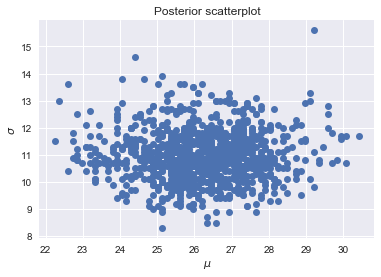

In [28]:
plt.plot(sampled_posterior[:1000, 0], sampled_posterior[:1000, 1], 'o')
plt.title('Posterior scatterplot')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')

**4.5. Experiment with reducing the grid size down to 100x100. How do the marginal posteriors now look? What does this look tell us about the dimensional scaling of this grid-sampling-in-proportion-to-posterior method of obtaining samples?**

Text(0.5,1,'Posetrior standard deviation')

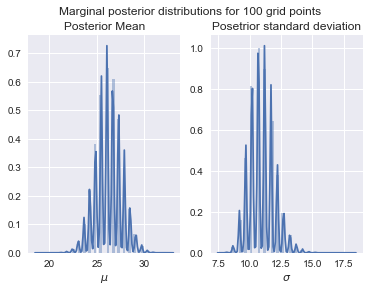

In [29]:
n_grid = 100
pdf_grid, mus, sigmas = compute_pdf(n_grid, light_speed)
sampled_posterior = compute_samples(n_samples, mus, sigmas, pdf_grid)

f, axarr = plt.subplots(ncols=2)
f.suptitle('Marginal posterior distributions for {} grid points'.format(n_grid))
sns.distplot(sampled_posterior[:, 0], ax=axarr[0], axlabel=r"$\mu$")
sns.distplot(sampled_posterior[:, 1], ax=axarr[1], axlabel=r"$\sigma$")
axarr[0].set_title("Posterior Mean")
axarr[1].set_title("Posetrior standard deviation")

Now, the marginal posterior distributions look "bumpy", meaning that the $\mu$ and $\sigma$ values are now sampled at relatively few discrete values. 

This tells us that we have a problem when we go to higher dimensions: we need to compute the value of the pdf at $n_{\text{grid}}^{\text{dim}}$, where $n_{\text{grid}}$ is the number of grid points per dimension and $\text{dim}$ is the number of dimensions under consideration. If we need at least 500 points per dimension, then in 5 dimensions, we already need $500^5 = \text{very big number}$ grid points. In really large dimensions (like neural networks), the problem is intractable.

**4.6. Now draw from the data sampling normal distribution to obtain the posterior-predictive distribution. You will have as many samples as the size of the posterior. Plot the posterior predictive distribution against the data, and write down your observations.**

We go back to 500 grid points:

In [30]:
n_grid = 500
pdf_grid, mus, sigmas = compute_pdf(n_grid, light_speed)
sampled_posterior = compute_samples(n_samples, mus, sigmas, pdf_grid)

Text(0,0.5,'Density')

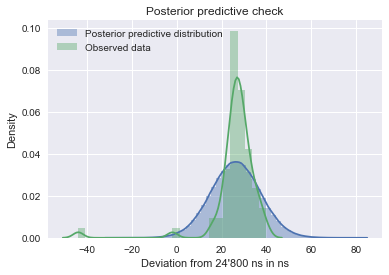

In [31]:
ppd = np.random.normal(size=sampled_posterior.shape[0], loc=sampled_posterior[:, 0], scale=sampled_posterior[:, 1])

sns.distplot(ppd, label="Posterior predictive distribution")
sns.distplot(light_speed, label="Observed data")
plt.title("Posterior predictive check")
plt.legend()
plt.xlabel("Deviation from 24'800 ns in ns")
plt.ylabel("Density")

We see that the observed data and the posterior predicitve distribution (ppd) do not match accurately:

+ The ppd is seemingly more spread out than the actual data
+ The center of mass seems to match roughly between the two distributions

The reason, we say that the ppd is "seemingly" more spread out is that, as humans, we often tend to ignore the outliers. The poseterior distribution does not ignore these outliers. So it's quite natural to ask, what happens to the posterior predictive distribution if we remove those two outliers:

In [32]:
n_grid = 500
pdf_grid, mus, sigmas = compute_pdf(n_grid, light_speed[light_speed >= 0])
sampled_posterior = compute_samples(n_samples, mus, sigmas, pdf_grid)

Text(0,0.5,'Density')

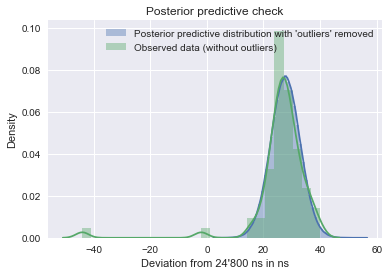

In [33]:
ppd = np.random.normal(size=sampled_posterior.shape[0], loc=sampled_posterior[:, 0], scale=sampled_posterior[:, 1])

sns.distplot(ppd, label="Posterior predictive distribution with 'outliers' removed")
sns.distplot(light_speed, label="Observed data (without outliers)")
plt.title("Posterior predictive check")
plt.legend()
plt.xlabel("Deviation from 24'800 ns in ns")
plt.ylabel("Density")

We see that after removing the outliers, the posterior predicitve and the observed data match very well.

4.7. **Informally using a test-statistic**

**We might wish to compute a test statistic from the posterior predictive. Say for example, we wish to talk about the minimum value of the posterior predictive.**

**The way to do this is to replicate the posterior predictive multiple times. We replicate the posterior-predictive (that is, do the sampling you did in 4.6) 66 times, which is the size of our dataset. In other words, we create as-many artificial datasets as there are samples in our posterior.**

**This is called a *replicative posterior predictive* **.

**Compute the replicative distribution of the minimum-value of the dataset and compare it to the actual value. What might you conclude about the quality of the specification of our model for the purposes of computing minimum values?**

We go back to the posterior with the outliers included:

In [34]:
n_grid = 500
pdf_grid, mus, sigmas = compute_pdf(n_grid, light_speed)
sampled_posterior = compute_samples(n_samples, mus, sigmas, pdf_grid)

In [35]:
n_data = light_speed.shape[0]
rpp = np.random.normal(size=(sampled_posterior.shape[0], n_data), 
                       loc=np.repeat(sampled_posterior[:, 0], repeats=n_data).reshape(-1, n_data),
                       scale=np.repeat(sampled_posterior[:, 1], repeats=n_data).reshape(-1, n_data))

replicative_mins = np.min(rpp, axis=1)

Text(0.5,1,'The observed minimum cannot be explained by the posterior distribution')

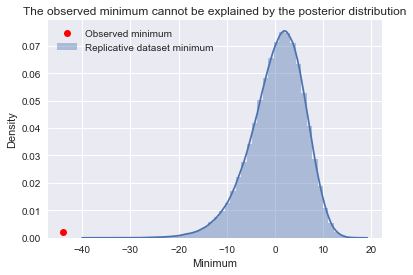

In [36]:
sns.distplot(replicative_mins, label='Replicative dataset minimum')
plt.plot(np.min(light_speed), 0.002, 'o', color='red', label='Observed minimum')
plt.legend()
plt.xlabel('Minimum')
plt.ylabel('Density')
plt.title('The observed minimum cannot be explained by the posterior distribution')

We can see that the observed minimum is close to impossible from the standpoint of the posterior distribution. This can either tell us something about our model being wrong or about an error in the data. Either way, we see that we have to investigate this point further.